# Setting up a Dask Cluster on AzureML

In this lesson, we'll be using a dask cluster to replicate the [exercise we did in the Big Data section](exercises/Exercise_bigdata.ipynb) where we loaded global temperature data to measure global warming at a number of locations. You can get the data we're using for this [exercise here](https://www.dropbox.com/s/oq36w90hm9ltgvc/global_climate_data.zip?dl=0)). 

If you want to follow along, just decompress the `ghcnd_daily.tar.gz` file and upload the resulting `.csv` into a Blob container using the web interface. Note this will take a little while. Will talk about more efficient methods of upload in our next tutorial.

To run this code, in addition the `dask` and `pandas`, which you should already have installed, you'll need to install the following packages (`azureml-sdk` and `dask_cloudprovider`) with the following commands:

```
conda install -c conda-forge azure-storage-blob # For managing storage
pip install azureml-sdk                         # For managing compute
pip install dask_cloudprovider=0.4.1
```

Note that `dask_cloudprovider` sometimes doesn't load the right version if you don't specify, and as of October 2020 the right version isn't even on `conda-forge`, so don't use `conda install`. You can also pip install `azure-storage-blob` if you prefer `pip` to `conda`. 

## Starting a Dask Cluster

In [1]:
%load_ext lab_black
from azureml.core import Workspace, Experiment
from dask_cloudprovider import AzureMLCluster

In [2]:
# I'm gonna load my subscription_id,
# resource_group, and workspace_name from a hidden file
# so y'all can't see them! You can just put in your code
# if its private.

import json

with open("/users/nick/azure_secrets/azure_config.json") as f:
    account = json.load(f)

In [3]:
# Register workspace with account info
ws = Workspace(
    subscription_id=account["subscription_id"],
    resource_group=account["resource_group"],
    workspace_name=account["workspace_name"],
)

In [4]:
# Start up a cluster!
amlcluster = AzureMLCluster(
    ws,
    vm_size="STANDARD_DS13_V2",  # Azure VM size for the Compute Target,
    datastores=ws.datastores.values(),  # Azure ML Datastores to mount on the headnode
    environment_definition=ws.environments[
        "AzureML-Dask-CPU"
    ],  # Azure ML Environment to run on the cluster
    jupyter=True,  # Flag to start JupyterLab session on the headnode
    initial_node_count=2,  # number of nodes to start
    scheduler_idle_timeout=7200,  # scheduler idle timeout in seconds
)

WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.
WARNING - If 'arguments' has been provided here and arguments have been specified in 'run_config', 'arguments' provided in ScriptRunConfig initialization will take precedence.


.................................................................



WARNING - If 'script' has been provided here and a script file name has been specified in 'run_config', 'script' provided in ScriptRunConfig initialization will take precedence.


In [5]:
amlcluster

## Using Your Cluster

There are two ways to use your cluster: You can click on the link above to open a connection to JupyterLab running on one of the computers in your cluster, or connect from here with this command:

In [6]:
from dask.distributed import Client

c = Client(amlcluster)

/Users/Nick/miniconda3/lib/python3.7/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| numpy   | 1.19.1        | 1.19.2        | 1.19.2        |
| python  | 3.7.8.final.0 | 3.6.9.final.0 | 3.6.9.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


And you're off to the races! One note though -- if you decide to work from your own computer, you may get a warning about version differences between `dask` on the cloud on and on your own computer. I initially got:

```
/Users/Nick/miniconda3/lib/python3.7/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| lz4     | None          | 3.1.0         | 3.1.0         |
| numpy   | 1.19.1        | 1.19.2        | 1.19.2        |
| python  | 3.7.8.final.0 | 3.6.9.final.0 | 3.6.9.final.0 |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))
```

The `numpy` and `python` issues don't seem like to cause big problems (though if you have a mismatch and get problems down the road, consider changing your Python version!), but the fact that the schedulers and workers have one package I don't (`lz4`) is a problem, so I installed it before moving forward. (`lz4` is a compression algorithm used to send data back and forth, so not having it is a big problem).

First, we'll contect to the container where I put the climate data. As you saw in the last exercise, you can upload data using the Azure web interface, and I would do that if you want to do these exercises. However there are more efficient tools we'll cover in the [next lesson](cloud_azurestorage.ipynb).

In [7]:
from azure.storage.blob import BlobServiceClient

# Load connection string so y'all can't see it!
with open("/users/nick/azure_secrets/azure_sa_connection_string.txt") as f:
    connection_string = f.read()

# Connect to storage account
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container = blob_service_client.get_container_client("globaltemps")

# Look at the files in the container for sanity check.
for f in container.list_blobs():
    print(f["name"] + "\n")

.DS_Store

colorado_temps.parquet/_common_metadata

colorado_temps.parquet/_metadata

colorado_temps.parquet/part.33.parquet

ghcnd-countries.txt

ghcnd-states.txt

ghcnd-stations.txt

ghcnd-version.txt

ghcnd_daily.csv

ghcnd_daily.tar.gz

ghcnd_daily_30gb.dat

ghcnd_daily_30gb.tar.gz

readme.txt



The step above was a fun way to see what's in my folders, but it's not actually required for using `dask` because `dask` can access Azure storage without the help of any other libraries -- you just need to be able to pass it your Storage Account name and Access Key, which you can find by going to your Azure Portal, then your Storage Account, and then clicking on "Access Keys" on the left menu. The syntax is:

```
import dask.dataframe as dd

storage_options={'account_name': ACCOUNT_NAME, 'account_key': ACCOUNT_KEY}

ddf = dd.read_csv('az://{CONTAINER}/{FOLDER}/*.csv', storage_options=storage_options)
ddf = dd.read_parquet('az://{CONTAINER}/folder.parquet', storage_options=storage_options)
```

But since I don't want you to see all my secret codes, I'm gonna load my information from a file. You can do this, but you can also put them in your code *if your code isn't public!*

In [8]:
# Dask connects with a protocl
import json

with open("/users/nick/azure_secrets/azure_sa_name_and_key.json") as f:
    storage_options = json.load(f)

In [9]:
import dask.dataframe as dd

# dask things the flag columns are floats, when really objects.
flag_dict = {}
for i in range(1, 32):
    for flag in ["q", "m"]:
        flag_dict.update({f"{flag}flag{i}": "object"})

temps = dd.read_csv(
    f"az://globaltemps/ghcnd_daily.csv",
    storage_options=storage_options,
    dtype=flag_dict,
)

In [10]:
temps.head(10)

,id,year,month,element,value1,mflag1,qflag1,sflag1,value2,mflag2,...,qflag29,sflag29,value30,mflag30,qflag30,sflag30,value31,mflag31,qflag31,sflag31
0,ACW00011604,1949,1,TMAX,289,NaN,NaN,X,289,NaN,...,NaN,X,272,NaN,NaN,X,272,NaN,NaN,X
1,ACW00011604,1949,2,TMAX,267,NaN,NaN,X,278,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
2,ACW00011604,1949,3,TMAX,272,NaN,NaN,X,289,NaN,...,NaN,X,278,NaN,NaN,X,267,NaN,NaN,X
3,ACW00011604,1949,4,TMAX,278,NaN,NaN,X,283,NaN,...,NaN,X,289,NaN,NaN,X,-9999,NaN,NaN,NaN
4,ACW00011604,1949,5,TMAX,283,NaN,NaN,X,283,NaN,...,NaN,X,294,NaN,NaN,X,300,NaN,NaN,X
5,ACW00011604,1949,6,TMAX,300,NaN,NaN,X,294,NaN,...,NaN,X,294,NaN,NaN,X,-9999,NaN,NaN,NaN
6,ACW00011604,1949,7,TMAX,300,NaN,NaN,X,300,NaN,...,NaN,X,306,NaN,NaN,X,294,NaN,NaN,X
7,ACW00011647,1961,10,TMAX,272,NaN,NaN,X,-9999,NaN,...,NaN,NaN,-9999,NaN,NaN,NaN,-9999,NaN,NaN,NaN
8,AE000041196,1944,3,TMAX,-9999,NaN,NaN,NaN,-9999,NaN,...,NaN,I,396,NaN,NaN,I,313,NaN,NaN,I
9,AE000041196,1944,4,TMAX,258,NaN,NaN,I,263,NaN,...,NaN,I,346,NaN,NaN,I,-9999,NaN,NaN,NaN


You will see that I added some code to explicitly name the types of some columns (the flags). As you may recall from our other lesson, dask isn't great at type inference, and will otherwise assume those are `float` columns instead of `objects`. Without that code, I get this error:

```
/azureml-envs/azureml_c6bd17107f471892400d23146f291775/lib/python3.6/site-packages/dask/dataframe/io/csv.py in coerce_dtypes()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+---------+--------+----------+
| Column  | Found  | Expected |
+---------+--------+----------+
| qflag1  | object | float64  |
| qflag10 | object | float64  |
| qflag11 | object | float64  |
| qflag12 | object | float64  |
| qflag13 | object | float64  |
| qflag14 | object | float64  |
| qflag15 | object | float64  |
| qflag16 | object | float64  |
| qflag17 | object | float64  |
| qflag18 | object | float64  |
| qflag19 | object | float64  |
| qflag2  | object | float64  |
| qflag20 | object | float64  |
```

Let's start by asking `dask` to go through this entire dataset and just pull out data for the station near my home in Colorado, and calculating the average daily max-temp for each month:

In [11]:
temps = temps[temps["id"] == "USC00050848"]

Now as you may recall, `dask` hasn't actually run the code above -- it's just making a plan and waiting till I run `.compute()` to actually execute, so if I check on `temps`, I'll see:

In [12]:
temps

,id,year,month,element,value1,mflag1,qflag1,sflag1,value2,mflag2,qflag2,sflag2,value3,mflag3,qflag3,sflag3,value4,mflag4,qflag4,sflag4,value5,mflag5,qflag5,sflag5,value6,mflag6,qflag6,sflag6,value7,mflag7,qflag7,sflag7,value8,mflag8,qflag8,sflag8,value9,mflag9,qflag9,sflag9,value10,mflag10,qflag10,sflag10,value11,mflag11,qflag11,sflag11,value12,mflag12,qflag12,sflag12,value13,mflag13,qflag13,sflag13,value14,mflag14,qflag14,sflag14,value15,mflag15,qflag15,sflag15,value16,mflag16,qflag16,sflag16,value17,mflag17,qflag17,sflag17,value18,mflag18,qflag18,sflag18,value19,mflag19,qflag19,sflag19,value20,mflag20,qflag20,sflag20,value21,mflag21,qflag21,sflag21,value22,mflag22,qflag22,sflag22,value23,mflag23,qflag23,sflag23,value24,mflag24,qflag24,sflag24,value25,mflag25,qflag25,sflag25,value26,mflag26,qflag26,sflag26,value27,mflag27,qflag27,sflag27,value28,mflag28,qflag28,sflag28,value29,mflag29,qflag29,sflag29,value30,mflag30,qflag30,sflag30,value31,mflag31,qflag31,sflag31
npartitions=64,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,int64,int64,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object,int64,object,object,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Now since we'll most want to work with this data from one station, we can save this subset dataframe so we don't have to re-load the original data next time we run `.compute()`. This is a little inefficient -- if we knew what all our code was gonna be before we started, we'd just write all the code with compute at the end -- but for interactive data science, this kind of caching is helpful.

I would also note that this dataset is small enough that the *costs* of moving it to the cloud (in terms of your time, and the performance cost of dask moving data across network connections) are probably great enough you'd be better off just working on your computer. But I wanted an example I could run relatively quickly and easily. :)

In [13]:
# Note this command runs immediately.
temps.to_parquet(
    "az://globaltemps/colorado_temps.parquet",
    storage_options=storage_options,
    compression="lz4",
)

Now the really cool thing: if we use the link for our dashboard we got when we created our dask cluster, we can see our cluster working:

![azure_dask_firstdashboard](images/azure_dask_firstdashboard.png)

Cool! But wait, didn't we only have 2 nodes initially? 

We did! But `dask` knows it has work to do, and that more nodes would make it go faster, so it's adding nodes to the cluster. Indeed, if we check back after a minute we'll see we now have even more:

![azure_dask_scalingup](images/azure_dask_scalingup.png)


OK, now we have our subset, and we can calculate what we want. Note that in reality, the data for this one station is actually easily small enough to put on my own computer, so I could have just run `data_on_own_comp = temps.compute()` above and moved the final dataset to my computer. But that's only because I've chosen a kinda toy example, so let's keep working like it's really big.

In [14]:
co_temps = dd.read_parquet(
    path="az://globaltemps/colorado_temps.parquet", storage_options=storage_options
)
co_temps["value31"].value_counts().compute()

-9999    613
 122      23
 300      21
 244      20
 294      20
        ... 
-78        1
-67        1
-56        1
 361       1
 378       1
Name: value31, Length: 87, dtype: int64

So let's replace those with missing, calculate averages across all the days in each month, and also convert from 1/10th of a degree Centigrade to Centigrade units:

In [16]:
import numpy as np
import re

for i in range(1, 32):
    co_temps[f"value{i}"] = co_temps[f"value{i}"].replace(-9999, np.nan)

value_columns = [i for i in co_temps.columns if re.match("value.*", "value.*")]
co_temps["avg"] = co_temps[value_columns].mean(axis="columns")
co_temps["avg_C"] = co_temps["avg"] / 10

Now finally we can collect our results on our personal computer, create a "time" variable that uses years and months for plotting, and plot our temperatures!

In [17]:
co_temps["time"] = co_temps["year"] + (co_temps["month"] - 1) / 12
co_temps = co_temps[["time", "avg_C"]]
df = co_temps.compute()

/Users/Nick/miniconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


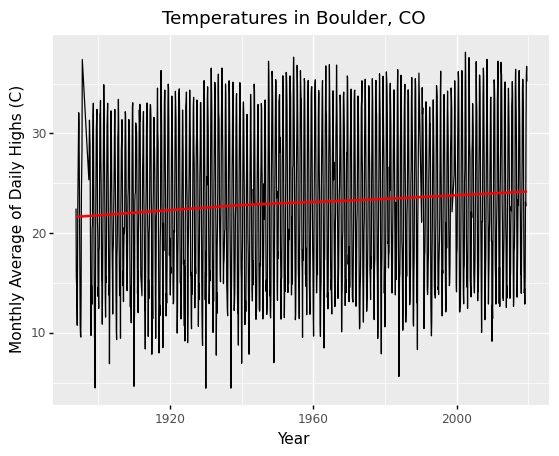

<ggplot: (8787089285597)>

In [18]:
from plotnine import *

(
    ggplot(df, aes(x="time", y="avg_C"))
    + geom_line()
    + geom_smooth(method="lowess", color="red")
    + ylab("Monthly Average of Daily Highs (C)")
    + xlab("Year")
    + ggtitle("Temperatures in Boulder, CO")
)

And that, my friends, is global warming. 

## Done with your cluster?

You have two options: you can shut it down manually with the method `.close()` on your cluster object. Thankfully, though, we also set a timeout condition when we created our cluster with the `scheduler_idle_timeout` keyword. We set it to 7200, so if your cluster is idle for two-hours, it will shut itself down (so you don't go broke). 

In [19]:
amlcluster.close()

tornado.application - ERROR - Exception in callback <bound method Client._heartbeat of <Client: 'tcp://10.0.0.4:8786' processes=2 threads=16, memory=118.15 GB>>
Traceback (most recent call last):
  File "/Users/Nick/miniconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 907, in _run
    return self.callback()
  File "/Users/Nick/miniconda3/lib/python3.7/site-packages/distributed/client.py", line 1174, in _heartbeat
    self.scheduler_comm.send({"op": "heartbeat-client"})
  File "/Users/Nick/miniconda3/lib/python3.7/site-packages/distributed/batched.py", line 117, in send
    raise CommClosedError
distributed.comm.core.CommClosedError


## Machine Learning

As a reminder, if you now want to do some machine learning, you can [use dask-ml on this system](https://ml.dask.org/)!

## Next Steps

OK, that's our short demo of computing on Azure with dask. I hope you found it useful!

As for next steps, I'd suggest the following readings, after which you should go play with your own project!

- [Managing Storage](cloud_azurestorage.ipynb): A discussion of better tools for uploading, downloading, and synchronizing data.
- [Mounting Storage](cloud_mountingazure.ipynb): A way to set-up easier access to your storage from your compute nodes.